# Benji, Wendi, Yiwen

Dataset can be downloaded at:

https://www.kaggle.com/zynicide/wine-reviews

In [1]:
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(gbm)
library(stringr)
library(forcats)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loaded gbm 2.1.4


Read in the data, drop duplicates, drop `description`, `winery`, and `taster_twitter_handle`.

In [2]:
read_csv("Data/wine-reviews/winemag-data-130k-v2.csv") %>% select(-X1) %>% unique %>% 
select(-description, -winery, -taster_twitter_handle) -> data

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  country = col_character(),
  description = col_character(),
  designation = col_character(),
  points = col_integer(),
  price = col_double(),
  province = col_character(),
  region_1 = col_character(),
  region_2 = col_character(),
  taster_name = col_character(),
  taster_twitter_handle = col_character(),
  title = col_character(),
  variety = col_character(),
  winery = col_character()
)


In this notebook, we will attempt to automate some of the data munging/imputation. 

We want to scale `points` by the taster, since the distribution of points is likely dependent on the taster. Therefore, we will attempt two different methods of unifying this distribution: scaling by standardization and scaling by percentile of score.

In [3]:
scale_taster <- function(points){
    # takes a vector of numbers, subtracts every element by the mean of the vector, and then
    # divides every element by the standard deviation of the vector
    
    return((points - mean(points, na.rm = TRUE)) / sd(points, na.rm = TRUE))
}

In [4]:
percentile_taster <- function(x){
    # takes a vector of numbers, ranks every element and divides by n, giving the percentile of each element
    trunc(rank(x))/length(x) * 100
}

In [5]:
data <- data %>% group_by(taster_name) %>% mutate("Scaled_Points" = scale_taster(points))

In [6]:
data <- data %>% group_by(taster_name) %>% mutate("Percentile_Points" = percentile_taster(points))

We want to reduce the number of provinces. If a given province only appears less than 1% of the time, we want to change that province to its country instead. However, we want to distinguish these miscellaneous provinces from the major ones, so we will call it `country_other`.

In [7]:
tab <- data %>% group_by(province) %>% summarize("Proportion" = n()/nrow(data))
tab <- tab[tab$Proportion > 0.01, ]

tabcountry <-  data %>% group_by(country) %>% summarize("Proportion" = n()/nrow(data))
tabcountry <- tabcountry[tabcountry$Proportion > 0.01, ]

In [8]:
data$country_other <- ifelse(data$country %in% tabcountry$country, 
                                paste0(data$country, "_other"), data$country)
data$location <- ifelse(data$province %in% tab$province, data$province,
                                     data$country_other)

Now that we have consolidated provinces under the `location` variable, we can drop `province` and `country_other` since we no longer have any need for them.

In [9]:
data <- data %>% select(-province, -country_other)

We can extract the year that the wine was produced from its title:

In [10]:
year <- str_extract_all(data$title, "[0-9]{4}")

In [11]:
data$year <- lapply(year, function(x){
    x = x %>% as.numeric
    if(!all(is.na(x))){
        newx <- x[(x > 1900) & (x < 2018)]
        if(!all(is.na(newx))){
            newx <- max(newx)
            return(newx)
        }
        else{
            return(NA)
        }
    }
    else {
        return(NA) 
    }}) %>% unlist

Drop `region_1`, `region_2`, and `designation` due to too many unique values. Also drop title and country since we no longer need them.

In [12]:
data <- data %>% select(-region_1, -region_2, -designation, -title, -country)

Impute "Missing" category for the observations with `taster_name = NA`

In [13]:
data[which(is.na(data$taster_name)), ]$taster_name <- "Missing"

We want to impute `price` by the average price of the missing wine's variety, i.e. we will group by variety, take the mean, and then use that value to impute. However, we won't be able to impute the price of wines where the variety has only missing prices because then the mean wouldn't be defined. Thus, these cases will be removed.

In [14]:
impute_mean <- function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))
    # impute_mean replaces missing values with the average value of a group

In [15]:
clean <- function(df){
    # clean removes the varieties that only have missing prices, and are thus unimputable by our rule,
    # and then it imputes the remaining missing prices using the average price of that wine's variety
    
    df %>% group_by(variety) %>% summarize("Average_Price" = mean(price, na.rm = T), 
                                           "Count" = n()) %>% 
    filter(is.na(Average_Price)) %>% select(variety) %>% unlist() -> drop_variety 
    
    df %>% filter(!(variety %in% drop_variety)) -> df
    
    df %>% group_by(variety) %>% mutate(price = impute_mean(price))
}

In [16]:
change_to_factor <- function(df){

    df$location <- factor(df$location)
    df$taster_name <- factor(df$taster_name)
    df$variety <- factor(df$variety)
    return(df)
}

In [17]:
data <- change_to_factor(data)

We must change our categorical variables to factors for our functions to handle them correctly.

# EDA

In [37]:
data %>% group_by(taster_name) %>% summarize(Count = n(), Proportion = Count/nrow(.)) %>% ungroup %>%
    rename(Taster = taster_name)-> temp

In [38]:
temp$Taster <- factor(temp$Taster, levels = temp$Taster[rev(order(temp$Proportion))])

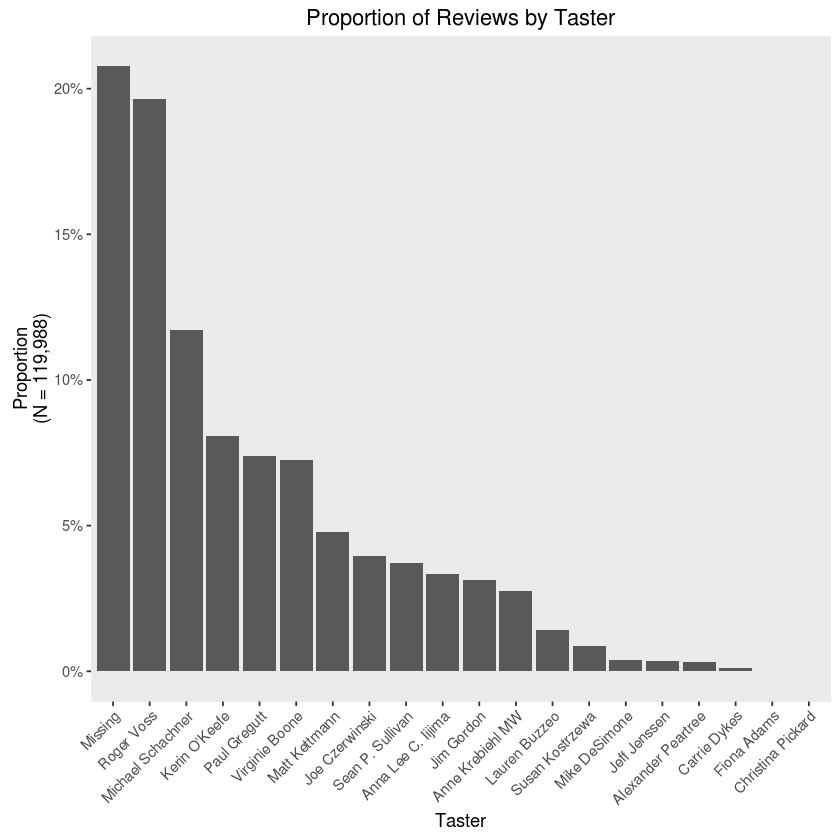

In [39]:
temp %>% ggplot(mapping = aes(x = Taster, y = Proportion)) + 
    geom_bar(stat = "identity") + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    labs(title = "Proportion of Reviews by Taster", y = "Proportion\n(N = 119,988)") +
    scale_y_continuous(labels = scales::percent) 

Warning message:
“Removed 8395 rows containing missing values (geom_point).”

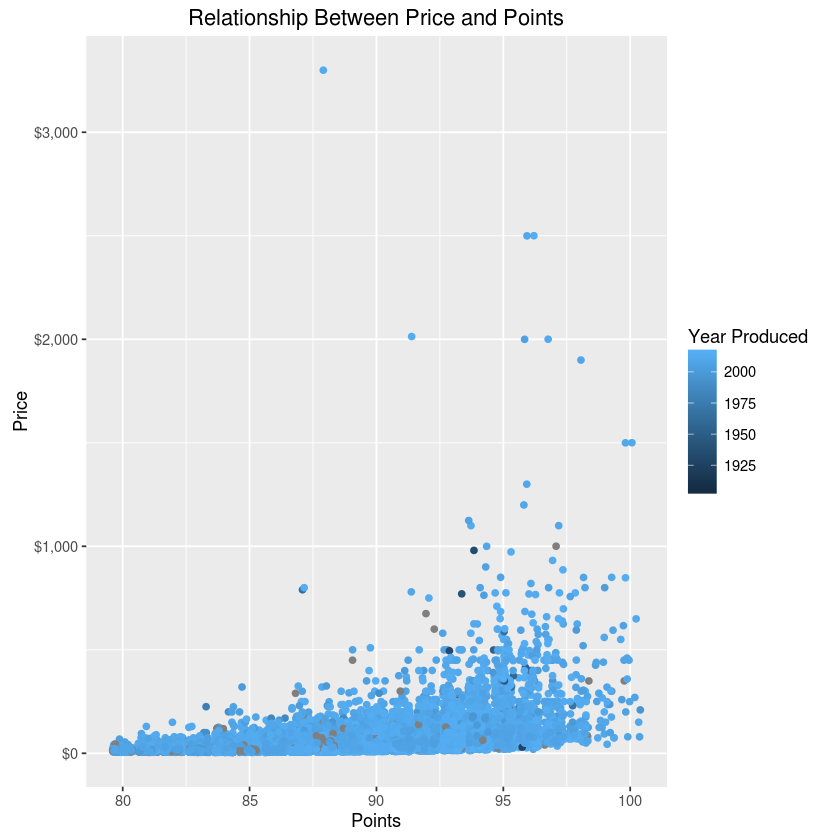

In [40]:
data %>% ggplot(mapping = aes(x = points, y = price, color = year)) + geom_jitter() +
    labs(title = "Relationship Between Price and Points", x = "Points", y = "Price", color = "Year Produced") +
    scale_y_continuous(labels = scales::dollar)

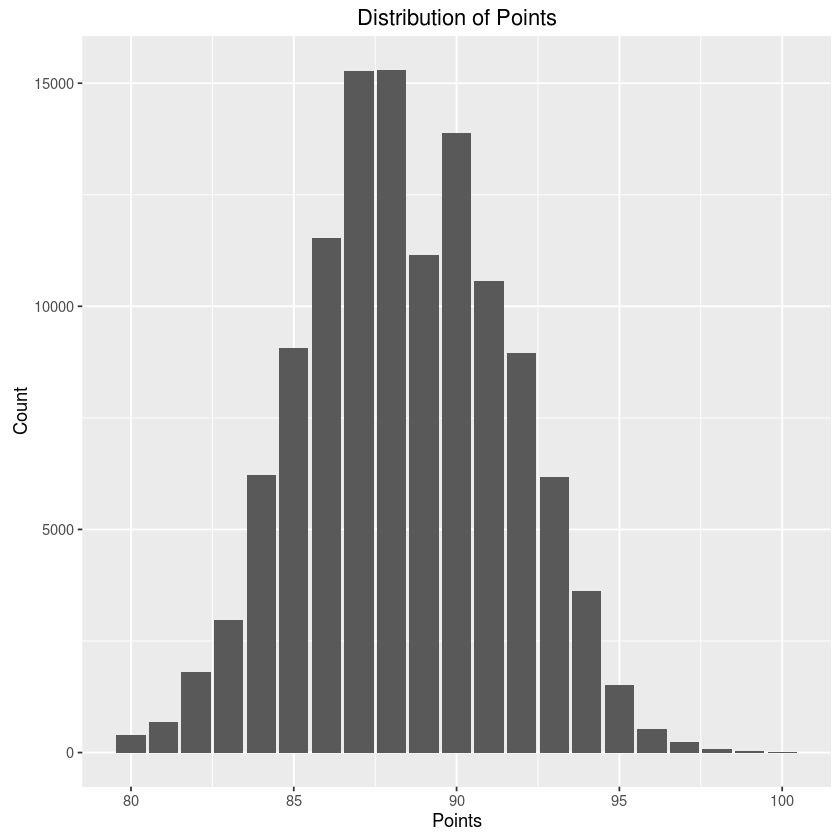

In [41]:
data %>% group_by(points) %>% summarize(Count = n()) %>%
    ggplot(mapping = aes(x = points, y = Count)) + geom_bar(stat = "identity") +
    theme(legend.position="none") + labs(title = "Distribution of Points", x = "Points")

In [164]:
matrix_names <- c(levels(data$taster_name), levels(data$location)[2:length(levels(data$location))])

#taster_dummy_matrix <- model.matrix(~ taster_name + 0, data = data)
#location_dummy_matrix <- model.matrix(~ location + 0, data = data)
dummy_matrix <- model.matrix(~ taster_name + location + 0, data = data)
colnames(dummy_matrix) <- matrix_names

In [168]:
matrix_dist <- as.dist(1 - cor(dummy_matrix))

In [169]:
HA <- hclust(matrix_dist, method = "average")

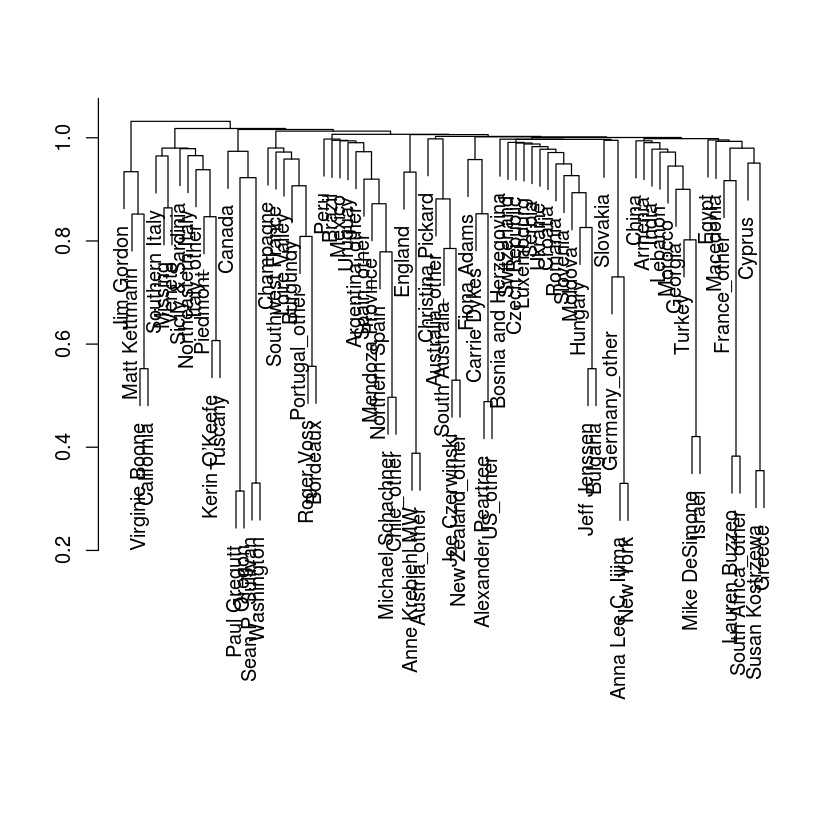

In [170]:
plot(HA, ann = FALSE, main="Dissimilarity = 1 - Correlation")

# Splitting Data

Let `data` be our entire dataset. Let's try splitting `data` so that 80% is training, and 20% is test. Then, let's try splitting our training data into 80% training, and 20% validation. NOTE: This means we partitioning our data into three groups.

In [ ]:
set.seed(2018)
train_indices <- sample.int(n = nrow(data), size = floor(.80 * nrow(data)), replace = FALSE)
# get random indices for 80% of whole data set

partition <- data[train_indices, ]
test <- data[-train_indices, ]

Note that we've only partitioned the data once, but we want another partition. This second partitioning step will take place within the cross-validation step, seen below.

# Gradient-Boosted Machine

## Training & Validating GBM Model:

10-Fold Cross-Validation:

Note: Here is where we will partition our training data into train and validation data.

In [ ]:
set.seed(2018)
k <- 10
sample <- partition %>% select(-points, -Scaled_Points)
sp <- split(c(1:nrow(sample)), c(1:k))
mse_error <- c()
mae_error <- c()

for(i in 1:k){
    # First we impute the missing prices
    train <- clean(sample[-sp[[k]], ])
    validate <- clean(sample[sp[[k]], ])
    
    # Take note of the formula here, price ~ taster_name + variety + Percentile_Points + location + year
    gbmFit <- gbm(formula = price ~ taster_name + variety + Percentile_Points + location + year, data = train, 
                  n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, n.cores = 4,
                  distribution = "laplace")

    best_iter <- gbm.perf(gbmFit, method = "cv")
    
    se <- (validate$price - predict(gbmFit, newdata = validate, n.trees = best_iter))^2
    ae <- abs(validate$price - predict(gbmFit, newdata = validate, n.trees = best_iter))
    mse_error <- c(mse_error, mean(se, na.rm = TRUE))
    mae_error <- c(mae_error, mean(ae, na.rm = TRUE))
}

In [ ]:
error_df <- data.frame("KFold" = 1:k, "SquaredError" = mse_error, "AbsoluteError" = mae_error)
print(error_df)

### Performance Using MAE

In [ ]:
mae_fold <- which(error_df$AbsoluteError == min(error_df$AbsoluteError))
paste0("We will use fold #", mae_fold, " to train our model.")

We will assess our model on the test/hold-out data set. Note that we are only calculating MAE here.

In [ ]:
train <- clean(sample[-sp[[mae_fold]], ])
    
gbmFit <- gbm(formula = price ~ taster_name + variety + Percentile_Points + location + year, data = train,
              n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, n.cores = 4,
              distribution = "laplace")

best_iter <- gbm.perf(gbmFit, method = "cv")
    
ae <- abs(test$price - predict(gbmFit, newdata = test, n.trees = best_iter))

In [ ]:
print(mean(ae, na.rm = TRUE)) # our final performance on the test data

### Performance Using MSE

In [ ]:
mse_fold <- which(error_df$SquaredError == min(error_df$SquaredError))
paste0("We will use fold #", mse_fold, " to train our model.")

In [ ]:
train <- clean(sample[-sp[[mse_fold]], ])
    
gbmFit <- gbm(formula = price ~ taster_name + variety + Percentile_Points + location + year, data = train,
              n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, n.cores = 4,
              distribution = "laplace")

best_iter <- gbm.perf(gbmFit, method = "cv")
    
se <- (test$price - predict(gbmFit, newdata = test, n.trees = best_iter))^2

In [ ]:
print(mean(se, na.rm = TRUE)) # our final performance on the test data

## Repeat GBM but with Different Model:

In [ ]:
set.seed(2018)
k <- 10
sample <- partition %>% select(-Percentile_Points, -Scaled_Points)
sp <- split(c(1:nrow(sample)), c(1:k))
mse_error <- c()
mae_error <- c()

for(i in 1:k){
    # First we impute the missing prices
    train <- clean(sample[-sp[[k]], ])
    validate <- clean(sample[sp[[k]], ])
    
    # Take note of the formula here, points ~ taster_name + variety + price + location + year
    gbmFit <- gbm(formula = points ~ taster_name + variety + price + location + year, data = train, 
                  n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, n.cores = 4,
                  distribution = "laplace")

    best_iter <- gbm.perf(gbmFit, method = "cv")
    
    se <- (validate$points - predict(gbmFit, newdata = validate, n.trees = best_iter))^2
    ae <- abs(validate$points - predict(gbmFit, newdata = validate, n.trees = best_iter))
    mse_error <- c(mse_error, mean(se, na.rm = TRUE))
    mae_error <- c(mae_error, mean(ae, na.rm = TRUE))
}

In [ ]:
error_df <- data.frame("KFold" = 1:k, "SquaredError" = mse_error, "AbsoluteError" = mae_error)
print(error_df)

### Performance Using MAE

In [ ]:
mae_fold <- which(error_df$AbsoluteError == min(error_df$AbsoluteError))
paste0("We will use fold #", mae_fold, " to train our model.")

In [ ]:
train <- clean(sample[-sp[[mae_fold]], ])
    
gbmFit <- gbm(formula = points ~ taster_name + variety + price + location + year, data = train,
              n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, n.cores = 4,
              distribution = "laplace")

best_iter <- gbm.perf(gbmFit, method = "cv")
    
ae <- abs(test$points - predict(gbmFit, newdata = test, n.trees = best_iter))

In [ ]:
print(mean(ae, na.rm = TRUE)) # our final performance on the test data

### Performance using MSE

In [ ]:
mse_fold <- which(error_df$SquaredError == min(error_df$SquaredError))
paste0("We will use fold #", mse_fold, " to train our model.")

In [ ]:
train <- clean(sample[-sp[[mse_fold]], ])
    
gbmFit <- gbm(formula = points ~ taster_name + variety + price + location + year, data = train,
              n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, n.cores = 4,
              distribution = "laplace")

best_iter <- gbm.perf(gbmFit, method = "cv")
    
se <- (test$points - predict(gbmFit, newdata = test, n.trees = best_iter))^2

In [ ]:
print(mean(se, na.rm = TRUE)) # our final performance on the test data